In [ ]:
import azureml.core
azureml.core.VERSION

In [ ]:
import sys
sys.path

In [ ]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
from matplotlib import pyplot as plt
from scipy.stats import pointbiserialr
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import (accuracy_score, log_loss, classification_report)

### Connect to previously created workspace

In [ ]:
from azureml.core import Workspace
ws = Workspace.from_config()

In [ ]:
ws.get_default_datastore()

### Connect to datastore and load the data

In [ ]:
# Register a new datastore
from azureml.core import Datastore

blob_ds = Datastore.register_azure_blob_container(workspace=ws,
    datastore_name='insert datastore name here',
    container_name='insert container name here',
    account_name='insert account name here',
    account_key='insert your key here')

In [ ]:
for ds_name in ws.datastores:
    print(ds_name)

In [ ]:
from azureml.core import Workspace, Datastore, Dataset


datastore_name = 'kdd'

    
# retrieve an existing datastore in the workspace by name
datastore = Datastore.get(ws, datastore_name)


# create a TabularDataset from 3 file paths in datastore
datastore_paths = [(datastore, 'kdd/data_10_percent.csv')]


data = Dataset.Tabular.from_delimited_files(path=datastore_paths)

In [ ]:
data.take(3).to_pandas_dataframe()

In [ ]:
data = data.to_pandas_dataframe()
data.shape

In [ ]:
# count types/frequencies of connection types
data.type.value_counts() #(145585-87831=57754 bad connections) Need 1455 to be about 1%. Want variety but also enough to train.


### DOS and DDoS
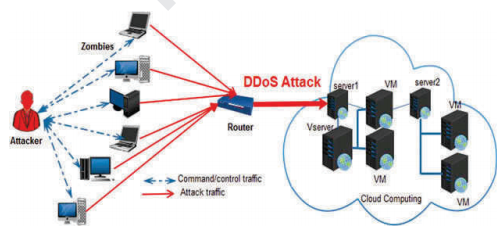

- A denial-of-service attack overwhelms a system’s resources so that it cannot respond to service requests. A DDoS attack is also an attack on system’s resources, but it is launched from a large number of other host machines that are infected by malicious software controlled by the attacker.

- Types of DoS:

-Volumetric attacks: In this form of attack, the attacker continuously sends a huge amount of packets for the purpose of saturating the network bandwidth of the target. This attack denies the legitimate users access to the target. Example: NTP amplification, DNS amplification, UDP flood, TCP flood.
        
-Protocol attacks: In this form of attack, the attacker consumes all the resources of the victim’s server, such as processing capacity, firewall, memory, and so on. This attack exploits a vulnerability of the transport and application layers. Example: SYN (synchronization) flood, Ping of Death.
        
-Application Attacks: In this form of attack, the attacker continuously sends Hyper Text Transfer Protocol (HTTP) requests to the Web server with the purpose of crashing it. Example: HTTP flood, Attack on DNS services.
        
        

In [ ]:
#filter normal activity +4336 DOS connections
#DOS: back (968), land(19), neptune(51,820- sample 1584), pod(206), smurf (641) and teardrop (918)
neptune = data[(data['type'] == 'neptune.')]
neptune = neptune.sample(n=1584, random_state=1)

kdd_dos = data[(data['type'] == 'back.') |
        (data['type']== 'land.') |
        (data['type'] == 'pod.') |
        (data['type'] == 'smurf') |
        (data['type'] == 'teardrop.')|
        (data['type'] =='normal.')]

frame = [kdd_dos, neptune]
kdd_dos = pd.concat(frame)

### Exploration

In [ ]:
summary = kdd_dos.describe()
summary

In [ ]:
#protocol type exploration
kdd_dos.protocol_type.value_counts()
#tcp     78359
#udp     12069
#icmp     1098
#Name: protocol_type, dtype: int64
kdd_dos.groupby('type')['protocol_type'].value_counts()
sns.catplot(x="protocol_type", hue="type", kind="count", data=kdd_dos)

In [ ]:
#flags: s0(connection attempt seen, no reply), s1(connection established, not terminated(0byte counts)), sf(normal establish and terminated), REJ(connection attempt rejected), s2(established,ORIG attempts close, no reply from resp), s3(established, RESP attempts close, no reply from ORIG)
kdd_dos.flag.value_counts()
kdd_dos.groupby('type')['flag'].value_counts()
#sns.catplot(x="type", hue="flag", kind="swarm", data=kdd_dos)

In [ ]:
# make conection type binary (DOS or Normal)
kdd_dos['DOS_type'] = np.where(kdd_dos['type'].str.contains("normal."),0,1)
kdd_dos.tail()

In [ ]:
kdd_dos.DOS_type.value_counts()

In [ ]:
kdd_dos_binary = kdd_dos.drop(['type'], axis=1)

In [ ]:
kdd_dos_binary.info()

### Correlations

In [ ]:
num_cols = ['duration', 'src_bytes',
       'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'hot',
       'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell',
       'su_attempted', 'num_root', 'num_file_creations', 'num_shells',
       'num_access_files', 'num_outbound_cmds', 'is_host_login',
       'is_guest_login', 'count', 'srv_count', 'serror_rate',
       'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate',
       'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count',
       'dst_host_srv_count', 'dst_host_same_srv_rate',
       'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate',
       'dst_host_srv_diff_host_rate', 'dst_host_serror_rate',
       'dst_host_srv_serror_rate', 'dst_host_rerror_rate',
       'dst_host_srv_rerror_rate', 'type', 'DOS_type']

In [ ]:
pbc = []
for col in num_cols:
    try:
        pbc.append(col)
        pbc.append(pointbiserialr(kdd_dos_binary[col], kdd_dos_binary['DOS_type']))
    except:
        print(col + ':There was an error')

In [ ]:
pbc

In [ ]:
#read in PBC data

datastore_paths = [(datastore, 'kdd/PBC.csv')]

pbc = Dataset.Tabular.from_delimited_files(path=datastore_paths)

pbc_df = pbc.to_pandas_dataframe()

pbc_df

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
plt.bar(pbc_df['column'], pbc_df['pbc'], color='green')
plt.xlabel("Column")
plt.ylabel("Correlation with Connection Type")
plt.title("Biserial Point Correlation of features with Connection Type (DOS/Normal)")
plt.xticks(rotation=90)
plt.rcParams['figure.figsize'] = [12, 8]

plt.show()

### Create an Experiment

##### Specify the experiment will run on local compute

In [ ]:
import os, shutil

# Create a folder for the experiment files
training_folder = 'kdd-training'
os.makedirs(training_folder, exist_ok=True)
print(training_folder, 'folder created')

In [ ]:
%%writefile $training_folder/AzureML_KDD_training.py

#import packagaes
from azureml.core import Run
import pandas as pd
import numpy as np
import os
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import (accuracy_score, log_loss, classification_report)

# Get the experiment run context
run = Run.get_context() 
print(run)

kdd = run.input_datasets['kdd'].to_pandas_dataframe()

X, y = kdd[['duration','src_bytes',
       'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'hot',
       'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell',
       'su_attempted', 'num_root', 'num_file_creations', 'num_shells',
       'num_access_files', 'num_outbound_cmds', 'is_host_login',
       'is_guest_login', 'count', 'srv_count', 'serror_rate',
       'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate',
       'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count',
       'dst_host_srv_count', 'dst_host_same_srv_rate',
       'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate',
       'dst_host_srv_diff_host_rate', 'dst_host_serror_rate',
       'dst_host_srv_serror_rate', 'dst_host_rerror_rate',
       'dst_host_srv_rerror_rate']].values, kdd['DOS_type'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 30, random_state=42)

# Set regularization hyperparameter
reg = 0.01

# Train a logistic regression model
print('Training a logistic regression model with regularization rate of', reg)
run.log('Regularization Rate',  np.float(reg))
model = LogisticRegression(C=1/reg, solver="liblinear").fit(X_train, y_train)

# calculate accuracy
y_hat = model.predict(X_test)
acc = np.average(y_hat == y_test)
print('Accuracy:', acc)
run.log('Accuracy', np.float(acc))

# calculate AUC
y_scores = model.predict_proba(X_test)
auc = roc_auc_score(y_test,y_scores[:,1])
print('AUC: ' + str(auc))
run.log('AUC', np.float(auc))

os.makedirs('outputs', exist_ok=True)
# note file saved in the outputs folder is automatically uploaded into experiment record
joblib.dump(value=model, filename='outputs/kdd_model.pkl')

run.complete()

### Run an Experiment on a Remote Compute Target

In [ ]:
from azureml.core.compute import ComputeTarget, AmlCompute
from azureml.core.compute_target import ComputeTargetException

cluster_name = "SQLBits"

try:
    # Check for existing compute target
    training_cluster = ComputeTarget(workspace=ws, name=cluster_name)
    print('Found existing cluster, use it.')
except ComputeTargetException:
    # If it doesn't already exist, create it
    try:
        compute_config = AmlCompute.provisioning_configuration(vm_size='STANDARD_DS11_V2', max_nodes=2)
        training_cluster = ComputeTarget.create(ws, cluster_name, compute_config)
        training_cluster.wait_for_completion(show_output=True)
    except Exception as ex:
        print(ex)
    

In [ ]:
from azureml.core import Environment
from azureml.core.conda_dependencies import CondaDependencies

# Create a Python environment for the experiment
cluster_env = Environment("cluster-env")
cluster_env.python.user_managed_dependencies = False # Let Azure ML manage dependencies
cluster_env.docker.enabled = True # Use a docker container

# Create a set of package dependencies (conda or pip as required)
cluster_packages = CondaDependencies.create(conda_packages=['scikit-learn'],
                                          pip_packages=['azureml-defaults', 'azureml-dataprep[pandas]'])

# Add the dependencies to the environment
cluster_env.python.conda_dependencies = cluster_packages

print(cluster_env.name, 'defined.')

In [ ]:
from azureml.train.estimator import Estimator
from azureml.core import Experiment
from azureml.widgets import RunDetails

# Get the environment
#registered_env = Environment.get(ws, 'kdd-env')

# Get the training dataset
#kdd = ws.datasets.get("kdd")


# Create an estimator
estimator = Estimator(source_directory=training_folder,
                      compute_target = cluster_name,
                      environment_definition = cluster_env,
                      entry_script='AzureML_KDD_training.py')

# Create an experiment
experiment = Experiment(workspace = ws, name = 'kdd-training')

# Run the experiment
run = experiment.submit(config=estimator)
# Show the run details while running
RunDetails(run).show()
run.wait_for_completion()